**PREVIS√ÉO DA PRODU√á√ÉO DE ENERGIA SOLAR E E√ìLICA NA FRAN√áA**

**Este projeto tem como objetivo desenvolver modelos preditivos robustos para estimar a produ√ß√£o hor√°ria de energia solar e energia e√≥lica na Fran√ßa, utilizando dados hist√≥ricos oficiais de gera√ß√£o combinados com vari√°veis temporais, estat√≠sticas e sazonais derivadas. Com os insights gerados, este projeto permite antecipar padr√µes de gera√ß√£o, apoiar o planejamento energ√©tico estrat√©gico, melhorar a integra√ß√£o √† rede el√©trica e otimizar o uso de fontes renov√°veis com maior efici√™ncia e seguran√ßa.**

In [1]:
# Importando Bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
from datetime import timedelta
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

In [2]:
# Carregando a base de dados
df = pd.read_csv('/content/intermittent-renewables-production-france.csv')

In [3]:
# Observando
df.head()

Date and Hour        Date StartHour   EndHour Source  \
0  2020-07-22 20:00:00+02:00  2020-07-22  20:00:00  21:00:00  Solar   
1  2020-07-23 07:00:00+02:00  2020-07-23  07:00:00  08:00:00  Solar   
2  2020-07-23 16:00:00+02:00  2020-07-23  16:00:00  17:00:00  Solar   
3  2020-07-23 19:00:00+02:00  2020-07-23  19:00:00  20:00:00  Solar   
4  2020-07-23 23:00:00+02:00  2020-07-23  23:00:00  24:00:00  Solar   

   Production  dayOfYear    dayName monthName  
0       244.0        204  Wednesday      July  
1       223.0        205   Thursday      July  
2      2517.0        205   Thursday      July  
3       658.0        205   Thursday      July  
4         0.0        205   Thursday      July

In [4]:
df.tail()

Date and Hour        Date StartHour   EndHour Source  \
59801  2023-06-30 06:00:00+02:00  2023-06-30  06:00:00  07:00:00  Solar   
59802  2023-06-30 13:00:00+02:00  2023-06-30  13:00:00  14:00:00  Solar   
59803  2023-06-30 14:00:00+02:00  2023-06-30  14:00:00  15:00:00  Solar   
59804  2023-06-30 16:00:00+02:00  2023-06-30  16:00:00  17:00:00  Solar   
59805  2023-06-30 18:00:00+02:00  2023-06-30  18:00:00  19:00:00  Solar   

       Production  dayOfYear dayName monthName  
59801        55.0        181  Friday      June  
59802      4554.0        181  Friday      June  
59803      4589.0        181  Friday      June  
59804      4173.0        181  Friday      June  
59805      2404.0        181  Friday      June

In [5]:
df.shape

(59806, 9)

In [6]:
# Informa√ß√µes sobre os tipos de vari√°veis
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59806 entries, 0 to 59805
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date and Hour  59806 non-null  object 
 1   Date           59806 non-null  object 
 2   StartHour      59806 non-null  object 
 3   EndHour        59806 non-null  object 
 4   Source         59806 non-null  object 
 5   Production     59804 non-null  float64
 6   dayOfYear      59806 non-null  int64  
 7   dayName        59806 non-null  object 
 8   monthName      59806 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 4.1+ MB


In [7]:
# Verificando a exist√™ncia de valores nulos
df.isnull().sum()

Date and Hour    0
Date             0
StartHour        0
EndHour          0
Source           0
Production       2
dayOfYear        0
dayName          0
monthName        0
dtype: int64

In [8]:
# Remover linhas onde 'Production' √© nulo
df = df.dropna(subset=['Production'])

In [9]:
df.isnull().sum()

Date and Hour    0
Date             0
StartHour        0
EndHour          0
Source           0
Production       0
dayOfYear        0
dayName          0
monthName        0
dtype: int64

In [10]:
# Converter coluna 'Date and Hour' para datetime
df['Date and Hour'] = pd.to_datetime(df['Date and Hour'])

# Ordenar cronologicamente (boa pr√°tica para s√©ries temporais)
df = df.sort_values('Date and Hour')

# Setar como √≠ndice
df.set_index('Date and Hour', inplace=True)

In [11]:
# Remover colunas que n√£o vamos usar agora
df.drop(columns=['Date', 'StartHour', 'EndHour'], inplace=True)

In [12]:
 # Corrigir o √≠ndice, convertendo com utc=True para evitar erro
df.index = pd.to_datetime(df.index, utc=True)

# Agora sim, voc√™ pode criar as features temporais
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month

In [13]:
df.drop(columns=['dayName', 'monthName'], inplace=True)

In [14]:
df.head()

Source  Production  dayOfYear  hour  dayofweek  \
Date and Hour                                                              
2019-12-31 23:00:00+00:00  Solar         0.0          1    23          1   
2019-12-31 23:00:00+00:00   Wind      3549.0          1    23          1   
2020-01-01 00:00:00+00:00   Wind      2952.0          1     0          2   
2020-01-01 00:00:00+00:00  Solar         0.0          1     0          2   
2020-01-01 01:00:00+00:00   Wind      2722.0          1     1          2   

                           month  
Date and Hour                     
2019-12-31 23:00:00+00:00     12  
2019-12-31 23:00:00+00:00     12  
2020-01-01 00:00:00+00:00      1  
2020-01-01 00:00:00+00:00      1  
2020-01-01 01:00:00+00:00      1

In [15]:
# Agrupar por dia e somar a produ√ß√£o por fonte
df_daily = df.pivot_table(values='Production', index=df.index.date, columns='Source', aggfunc='sum')

# Plotar a produ√ß√£o di√°ria de energia por fonte
plt.figure(figsize=(15, 6))
for col in df_daily.columns:
    plt.plot(df_daily.index, df_daily[col], label=col, linewidth=1.8)

plt.title('Produ√ß√£o Di√°ria de Energia Renov√°vel na Fran√ßa por Fonte')
plt.xlabel('Data')
plt.ylabel('Produ√ß√£o Total Di√°ria (MW)')
plt.legend(title='Fonte de Energia')
plt.grid(True)
plt.tight_layout()
plt.show()

**O gr√°fico acima apresenta a produ√ß√£o total di√°ria de energia renov√°vel na Fran√ßa, separada por fonte: Solar e Wind (que agrega e√≥lica onshore e offshore). A an√°lise revela padr√µes distintos entre as duas fontes:**

**Energia Solar:** Exibe um comportamento altamente sazonal, com produ√ß√£o crescente nos meses de ver√£o (junho a agosto) e decl√≠nio acentuado no inverno (dezembro a fevereiro). O padr√£o √© regular e previs√≠vel, tornando essa fonte ideal para modelos de previs√£o baseados em ciclos temporais.

**Energia E√≥lica:** Apresenta uma variabilidade muito mais acentuada, com picos e quedas di√°rias de grande amplitude. Apesar de mais irregular, a produ√ß√£o e√≥lica mant√©m n√≠veis relevantes ao longo de todo o ano, indicando sua import√¢ncia cont√≠nua no mix energ√©tico franc√™s.

In [16]:
# Dividir o dataframe por tipo de fonte
df_solar = df[df['Source'] == 'Solar'].copy()
df_wind = df[df['Source'] == 'Wind'].copy()

In [17]:
df_solar.head()

Source  Production  dayOfYear  hour  dayofweek  \
Date and Hour                                                              
2019-12-31 23:00:00+00:00  Solar         0.0          1    23          1   
2020-01-01 00:00:00+00:00  Solar         0.0          1     0          2   
2020-01-01 01:00:00+00:00  Solar         0.0          1     1          2   
2020-01-01 02:00:00+00:00  Solar         0.0          1     2          2   
2020-01-01 03:00:00+00:00  Solar         0.0          1     3          2   

                           month  
Date and Hour                     
2019-12-31 23:00:00+00:00     12  
2020-01-01 00:00:00+00:00      1  
2020-01-01 01:00:00+00:00      1  
2020-01-01 02:00:00+00:00      1  
2020-01-01 03:00:00+00:00      1

In [18]:
# Agregar produ√ß√£o por dia (somar todas as horas)
solar_daily = df_solar['Production'].resample('D').sum()

# Aplicar STL (Seasonal-Trend decomposition using Loess)
stl = STL(solar_daily, period=365, robust=True)
result = stl.fit()

# Plotar os componentes
plt.figure(figsize=(14, 8))
result.plot()
plt.suptitle('Decomposi√ß√£o STL da Produ√ß√£o Di√°ria de Energia Solar', fontsize=16)
plt.tight_layout()
plt.show()

<Figure size 1400x800 with 0 Axes>

**Acima observamos:**

**Trend (tend√™ncia):** Observa-se um crescimento constante na produ√ß√£o di√°ria de energia solar ao longo dos anos. Esse aumento pode estar relacionado √† expans√£o da capacidade instalada no pa√≠s, seja pela adi√ß√£o de novas usinas solares, avan√ßos tecnol√≥gicos ou incentivos governamentais voltados √† transi√ß√£o energ√©tica.

**Season (sazonalidade):** O padr√£o sazonal √© bem definido e est√°vel, refletindo a varia√ß√£o natural da radia√ß√£o solar ao longo do ano. Notamos que os picos ocorrem nos meses de ver√£o, enquanto os vales aparecem no inverno, com produ√ß√£o pr√≥xima de zero. Esse comportamento refor√ßa o car√°ter c√≠clico da fonte solar e sua alta previsibilidade.

**Resid (ru√≠dos):** Os res√≠duos mostram varia√ß√µes pontuais esperadas para esse tipo de gera√ß√£o, como dias nublados, manuten√ß√£o ou poss√≠veis falhas no registro. N√£o h√° nenhum padr√£o an√¥malo significativo, exceto por uma leve dispers√£o mais acentuada entre 2021 e 2022, possivelmente relacionada a fatores clim√°ticos ou operacionais.

In [19]:
# Criar um DataFrame auxiliar s√≥ com as vari√°veis tempor√°rias
df_temp = pd.DataFrame({
    'Production': df_solar['Production'].values,
    'hour': df_solar.index.hour,
    'dayofweek': df_solar.index.dayofweek
})

# Mapear nomes dos dias da semana
dias_nome = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'S√°b', 'Dom']
df_temp['day_name'] = df_temp['dayofweek'].map(lambda x: dias_nome[x])

# Criar pivot_table para o heatmap
pivot_table = df_temp.pivot_table(values='Production',
                                  index='hour',
                                  columns='day_name',
                                  aggfunc='mean')

# Reordenar colunas na ordem correta dos dias da semana
pivot_table = pivot_table[['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'S√°b', 'Dom']]

# Plotar heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt=".0f", linewidths=.5, cbar_kws={'label': 'MW'})
plt.title('Produ√ß√£o M√©dia de Energia Solar por Hora e Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Hora do Dia')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


**Acima percebemos que a janela √∫til de gera√ß√£o vai de 6h at√© 18h, com pico entre as 8h at√© 15h e m√°xima absoluta que ocorre √†s 12h e 13h, com m√©dia superior a 3400 MW.**

In [20]:
# Fun√ß√£o para identificar a esta√ß√£o do ano
def estacao_do_ano(data):
    mes = data.month
    dia = data.day
    if (mes == 12 and dia >= 21) or (mes in [1, 2]) or (mes == 3 and dia < 21):
        return 'Inverno'
    elif (mes == 3 and dia >= 21) or (mes in [4, 5]) or (mes == 6 and dia < 21):
        return 'Primavera'
    elif (mes == 6 and dia >= 21) or (mes in [7, 8]) or (mes == 9 and dia < 21):
        return 'Ver√£o'
    else:
        return 'Outono'

# Criar coluna com esta√ß√£o do ano
df_solar['estacao'] = df_solar.index.map(estacao_do_ano)

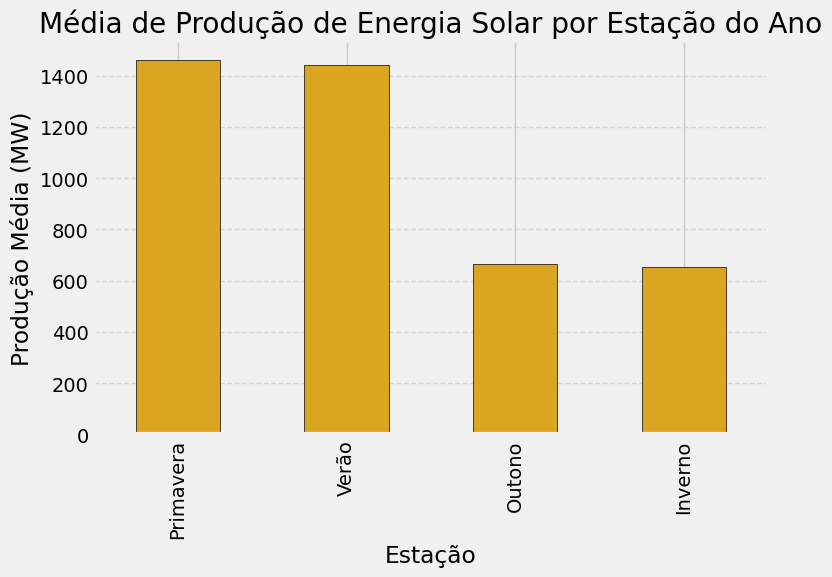

In [21]:
# Reordenar esta√ß√µes manualmente (opcional, para manter a sequ√™ncia l√≥gica)
ordem_estacoes = ['Primavera', 'Ver√£o', 'Outono', 'Inverno']
# Calcular m√©dia de produ√ß√£o por esta√ß√£o
media_por_estacao = df_solar.groupby('estacao')['Production'].mean().sort_values(ascending=False)
media_por_estacao = media_por_estacao.reindex(ordem_estacoes)

# Plotar gr√°fico de barras
plt.figure(figsize=(8, 6))
media_por_estacao.plot(kind='bar', color='goldenrod', edgecolor='black')

plt.title('M√©dia de Produ√ß√£o de Energia Solar por Esta√ß√£o do Ano')
plt.xlabel('Esta√ß√£o')
plt.ylabel('Produ√ß√£o M√©dia (MW)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**O gr√°fico acima nos diz claramente que na primavera e no ver√£o ocorre maior produ√ß√£o de energia solar com m√©dia di√°ria acima de 1400 MW. No outono e no inverno vemos uma produ√ß√£o muito inferior, refor√ßando o impacto da radia√ß√£o solar e inclina√ß√£o do sol no hemisf√©rio norte durante os meses mais frios.**

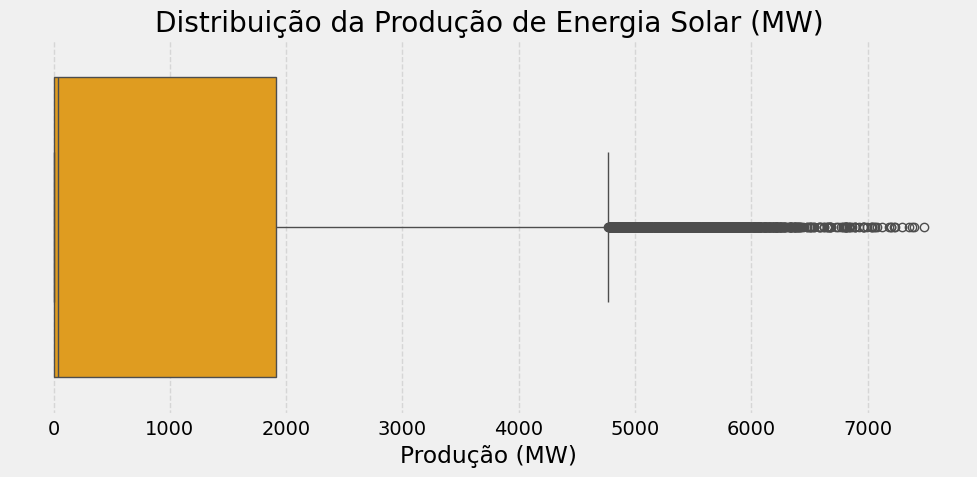

In [22]:
# Boxplot da produ√ß√£o solar total
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_solar['Production'], color='orange')
plt.title('Distribui√ß√£o da Produ√ß√£o de Energia Solar (MW)')
plt.xlabel('Produ√ß√£o (MW)')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [23]:
# Calcular limites usando o m√©todo interquartil (IQR)
Q1 = df_solar['Production'].quantile(0.25)
Q3 = df_solar['Production'].quantile(0.75)
IQR = Q3 - Q1

limite_superior = Q3 + 1.5 * IQR
limite_inferior = Q1 - 1.5 * IQR  # Normalmente n√£o ocorre no solar, mas colocamos por robustez

# Criar a vari√°vel is_outlier
df_solar['is_outlier'] = ((df_solar['Production'] > limite_superior) |
                          (df_solar['Production'] < limite_inferior)).astype(int)

In [24]:
# Criar vers√µes c√≠clicas
df_solar['hour_sin'] = np.sin(2 * np.pi * df_solar['hour'] / 24)
df_solar['hour_cos'] = np.cos(2 * np.pi * df_solar['hour'] / 24)

df_solar['dayofweek_sin'] = np.sin(2 * np.pi * df_solar['dayofweek'] / 7)
df_solar['dayofweek_cos'] = np.cos(2 * np.pi * df_solar['dayofweek'] / 7)

df_solar['month_sin'] = np.sin(2 * np.pi * df_solar['month'] / 12)
df_solar['month_cos'] = np.cos(2 * np.pi * df_solar['month'] / 12)

In [25]:
df_solar.drop(columns=['hour', 'dayofweek', 'month', 'Source'], inplace=True)

**Vamos criar legs temporais para ajudar o modelo a capturar padr√µes de persist√™ncia, tend√™ncia e ciclos de curto prazo, que s√£o comuns em s√©ries temporais. lag_1 representa a produ√ß√£o da √∫ltima hora, lag_2 das √∫ltimas 2h...Esse hist√≥rico √© essencial para que o modelo aprenda o comportamento recorrente da s√©rie ao longo do tempo e possa fazer previs√µes mais precisas**

In [26]:
# Legs temporais
for lag in [1, 2, 3, 6, 12, 24]:
    df_solar[f'lag_{lag}'] = df_solar['Production'].shift(lag)


**As m√©dias m√≥veis que vamos criar (rolling_mean) e os desvios padr√£o m√≥veis (rolling_std) s√£o usadas para capturar o comportamento local da s√©rie temporal, ou seja, como a produ√ß√£o de energia tem se comportado nas √∫ltimas horas. rolling_mean_6h: m√©dia da produ√ß√£o nas √∫ltimas 6 horas, mostra a tend√™ncia recente: rolling_std_6h: desvio padr√£o nas √∫ltimas 6 horas, mostra a variabilidade (ou estabilidade) recente. Essas vari√°veis ajudam o modelo a entender se a produ√ß√£o est√° em alta, baixa ou inst√°vel, fornecendo contexto din√¢mico para a previs√£o.**

In [27]:
# Medias m√≥veis
df_solar['rolling_mean_6h'] = df_solar['Production'].rolling(6).mean()
df_solar['rolling_mean_12h'] = df_solar['Production'].rolling(12).mean()
df_solar['rolling_std_6h'] = df_solar['Production'].rolling(6).std()
df_solar['rolling_std_12h'] = df_solar['Production'].rolling(12).std()


**A amplitude di√°ria √© a diferen√ßa entre o valor m√°ximo e o m√≠nimo da produ√ß√£o de energia em cada dia. Ela serve para capturar a varia√ß√£o total da produ√ß√£o solar ao longo do dia. Essa informa√ß√£o √© √∫til porque dias com alta amplitude geralmente indicam c√©u limpo, com muita radia√ß√£o solar (produ√ß√£o intensa ao meio-dia e baixa √† noite). J√° uma amplitude baixa pode indicar tempo nublado ou dias com pouca varia√ß√£o de luz solar. Com isso, o modelo entende o perfil clim√°tico e de produ√ß√£o daquele dia, o que ajuda bastante a melhorar a previs√£o, especialmente nos extremos (picos e vales).**

In [28]:
# Amplitude di√°ria
df_solar['daily_max'] = df_solar['Production'].groupby(df_solar.index.date).transform('max')
df_solar['daily_min'] = df_solar['Production'].groupby(df_solar.index.date).transform('min')
df_solar['daily_amp'] = df_solar['daily_max'] - df_solar['daily_min']

**Vamos criar a vari√°vel is_peak_solar_hour que ser√° uma flag bin√°ria que indica se a hora registrada est√° dentro do hor√°rio de pico solar, geralmente entre 10h e 15h.**

In [29]:
# Vari√°vel bin√°ria para hor√°rio de pico solar
df_solar['is_peak_solar_hour'] = ((df_solar.index.hour >= 10) & (df_solar.index.hour <= 15)).astype(int)


In [30]:
df_solar.dropna(inplace=True)

In [31]:
total_acima_6000 = (df_solar['Production'] > 6000).sum()
print(f"Total geral de valores > 6000: {total_acima_6000}")

Total geral de valores > 6000: 198


In [32]:
# Remover os registros com produ√ß√£o acima de 6000
df_solar = df_solar[df_solar['Production'] <= 6000].copy()

In [33]:
df_solar.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29679 entries, 2020-01-01 23:00:00+00:00 to 2023-06-30 21:00:00+00:00
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Production          29679 non-null  float64
 1   dayOfYear           29679 non-null  int64  
 2   estacao             29679 non-null  object 
 3   is_outlier          29679 non-null  int64  
 4   hour_sin            29679 non-null  float64
 5   hour_cos            29679 non-null  float64
 6   dayofweek_sin       29679 non-null  float64
 7   dayofweek_cos       29679 non-null  float64
 8   month_sin           29679 non-null  float64
 9   month_cos           29679 non-null  float64
 10  lag_1               29679 non-null  float64
 11  lag_2               29679 non-null  float64
 12  lag_3               29679 non-null  float64
 13  lag_6               29679 non-null  float64
 14  lag_12              29679 non-null  float64
 15  lag_24

In [34]:
# Aplicar One-Hot Encoding na vari√°vel 'estacao'
df_solar = pd.get_dummies(df_solar, columns=['estacao'], prefix='estacao', dtype=np.uint8)

# Checar se ainda h√° NaNs
print("Tem NaNs?", df_solar.isnull().sum().sum() > 0)


Tem NaNs? False


In [35]:
# Separar vari√°vel alvo
y = df_solar['Production']

# Separar preditoras (removendo a coluna alvo)
X = df_solar.drop(columns=['Production'])

In [36]:
# Tamanhos da base
n_total = len(X)
n_treino = int(n_total * 0.7)
n_val = int(n_total * 0.15)
n_teste = n_total - n_treino - n_val

# Separar em ordem cronol√≥gica
X_train = X.iloc[:n_treino]
y_train = y.iloc[:n_treino]

X_val = X.iloc[n_treino:n_treino+n_val]
y_val = y.iloc[n_treino:n_treino+n_val]

X_test = X.iloc[n_treino+n_val:]
y_test = y.iloc[n_treino+n_val:]

# Confirmar as dimens√µes
print(f'Treino: {X_train.shape}, Valida√ß√£o: {X_val.shape}, Teste: {X_test.shape}')

Treino: (20775, 26), Valida√ß√£o: (4451, 26), Teste: (4453, 26)


**A padroniza√ß√£o √© aplicada apenas √†s vari√°veis cont√≠nuas porque elas possuem escalas num√©ricas diferentes, o que pode confundir o modelo durante o treinamento. Ao padronizar, colocamos todas essas vari√°veis na mesma base (m√©dia 0 e desvio padr√£o 1), facilitando o aprendizado. J√° as vari√°veis categ√≥ricas (como as esta√ß√µes do ano codificadas com One-Hot) e bin√°rias (como is_outlier) n√£o precisam ser padronizadas. Elas j√° est√£o em uma escala consistente (valores 0 ou 1), e padronizar esses valores poderia atrapalhar a interpreta√ß√£o do modelo.**

In [37]:
# Identificando colunas num√©ricas cont√≠nuas (sem one-hot nem bin√°rias)
cols_to_scale = X_train.select_dtypes(include=['float64', 'int64']).columns
cols_to_scale = [col for col in cols_to_scale if not col.startswith('estacao_') and col != 'is_outlier']

# Inicializaando o scaler somente no treino
scaler = StandardScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])

# Aplicando transforma√ß√£o no val e teste
X_val[cols_to_scale] = scaler.transform(X_val[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

In [38]:
# Threshold para definir picos
threshold_peak = np.percentile(y_train, 80)

**Vamos usar uma estrat√©gia h√≠brida com dois modelos especializados, um para dados normais e outro para os picos de produ√ß√£o, por isso √© importante que cada modelo receba seus dados padronizados de forma adequada. Se utlizarmos o mesmo scaler para todos os dados, os valores muito altos (os picos) ficariam distorcidos pela m√©dia geral, dificultando o aprendizado do modelo de picos. Por isso, vamos escalonar separadamente: Modelo de dados normais vai receber os dados padronizados com base apenas na distribui√ß√£o dos valores normais. O modelo de picos vai receber os dados padronizados com base apenas nos dados de pico. Essa separa√ß√£o permite que cada modelo aprenda com mais precis√£o a faixa espec√≠fica que deve prever, melhorando o desempenho geral da solu√ß√£o.**

In [39]:
# Separar os dados entre normais e picos
idx_normais = y_train <= threshold_peak
idx_picos = y_train > threshold_peak

# Escalonar separadamente
scaler_normais = StandardScaler()
X_train_normais_scaled = scaler_normais.fit_transform(X_train[idx_normais])
y_train_normais = y_train[idx_normais]

scaler_picos = StandardScaler()
X_train_picos_scaled = scaler_picos.fit_transform(X_train[idx_picos])
y_train_picos = y_train[idx_picos]

In [40]:
# Modelos base
base_models = [
    ('rf', RandomForestRegressor(n_estimators=200, max_depth=2, random_state=42)),
    ('lasso', Lasso(alpha=0.1, max_iter=10000, random_state=42))
]
meta_model = LinearRegression()

# Modelo empilhado para normais
model_normais = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    passthrough=True,
    n_jobs=-1
)
model_normais.fit(X_train_normais_scaled, y_train_normais)

# Modelo XGBoost para picos
model_picos = XGBRegressor(n_estimators=300, max_depth=10, learning_rate=0.05,
                           objective='reg:squarederror', random_state=42)
model_picos.fit(X_train_picos_scaled, y_train_picos)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [41]:
# Escalonar dados de valida√ß√£o e teste
X_val_normais_scaled = scaler_normais.transform(X_val)
X_val_picos_scaled = scaler_picos.transform(X_val)
X_test_normais_scaled = scaler_normais.transform(X_test)
X_test_picos_scaled = scaler_picos.transform(X_test)

In [42]:
# Previs√µes
y_val_pred_normais = model_normais.predict(X_val_normais_scaled)
y_val_pred_picos = model_picos.predict(X_val_picos_scaled)
y_test_pred_normais = model_normais.predict(X_test_normais_scaled)
y_test_pred_picos = model_picos.predict(X_test_picos_scaled)

In [43]:
# Combinar: se previs√£o do modelo normal indicar pico, usamos o XGBoost
y_val_pred_hibrido = np.where(y_val_pred_normais > threshold_peak, y_val_pred_picos, y_val_pred_normais)
y_test_pred_hibrido = np.where(y_test_pred_normais > threshold_peak, y_test_pred_picos, y_test_pred_normais)

In [44]:
# Avalia√ß√£o - Valida√ß√£o
mae_val = mean_absolute_error(y_val, y_val_pred_hibrido)
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred_hibrido))
r2_val = r2_score(y_val, y_val_pred_hibrido)

print("üìä Avalia√ß√£o - Valida√ß√£o (Modelo Empilhado H√≠brido)")
print(f"MAE:  {mae_val:.2f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"R¬≤:   {r2_val:.4f}")
print("-" * 30)

# Avalia√ß√£o - Teste
mae_test = mean_absolute_error(y_test, y_test_pred_hibrido)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred_hibrido))
r2_test = r2_score(y_test, y_test_pred_hibrido)

print("üìä Avalia√ß√£o - Teste (Modelo Empilhado H√≠brido)")
print(f"MAE:  {mae_test:.2f}")
print(f"RMSE: {rmse_test:.2f}")
print(f"R¬≤:   {r2_test:.4f}")
print("-" * 30)

üìä Avalia√ß√£o - Valida√ß√£o (Modelo Empilhado H√≠brido)
MAE:  78.72
RMSE: 106.20
R¬≤:   0.9964
------------------------------
üìä Avalia√ß√£o - Teste (Modelo Empilhado H√≠brido)
MAE:  98.66
RMSE: 152.68
R¬≤:   0.9924
------------------------------


**MAE (Erro M√©dio Absoluto):** Em m√©dia, o modelo comete um erro de 78.72 unidades de energia na valida√ß√£o e 98.66 no teste. Considerando que a produ√ß√£o di√°ria pode ultrapassar facilmente os 6000, esses valores s√£o extremamente baixos, o que indica alta precis√£o nas previs√µes. A diferen√ßa pequena entre valida√ß√£o e teste tamb√©m √© um √≥timo sinal de generaliza√ß√£o, sem overfitting.

**RMSE (Raiz do Erro Quadr√°tico M√©dio):** Como esperado, o RMSE √© um pouco maior que o MAE (106.20 na valida√ß√£o e 152.68 no teste), o que mostra que o modelo n√£o cometeu grandes erros nos picos. Mesmo nos casos extremos, o modelo se manteve bem calibrado, controlando desvios fora da m√©dia.

**R¬≤ (Coeficiente de Determina√ß√£o):** O modelo explica 99.64% da vari√¢ncia na valida√ß√£o e 99.24% no teste, ou seja, praticamente toda a variabilidade da produ√ß√£o solar foi capturada. Isso mostra que o modelo aprendeu padr√µes reais e generalizou de forma excelente, sendo altamente confi√°vel para tomada de decis√£o.

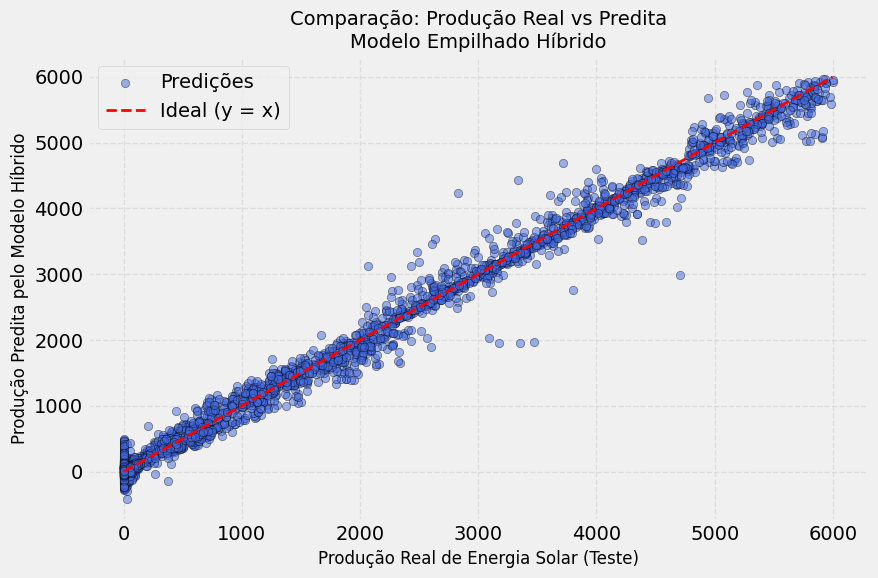

In [45]:
# Gr√°fico de dispers√£o: valores reais vs preditos no teste
plt.figure(figsize=(9, 6))
plt.scatter(y_test, y_test_pred_hibrido, alpha=0.5, color='royalblue', edgecolors='k', label='Predi√ß√µes')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label='Ideal (y = x)')
plt.xlabel("Produ√ß√£o Real de Energia Solar (Teste)", fontsize=12)
plt.ylabel("Produ√ß√£o Predita pelo Modelo H√≠brido", fontsize=12)
plt.title("Compara√ß√£o: Produ√ß√£o Real vs Predita\nModelo Empilhado H√≠brido", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

**O gr√°fico acima mostra a rela√ß√£o entre os valores reais de produ√ß√£o de energia solar e as predi√ß√µes geradas pelo modelo empilhado h√≠brido. A linha tracejada vermelha representa a linha ideal (y = x), onde os pontos estariam perfeitamente previstos. A proximidade dos pontos √† linha ideal indica alta precis√£o nas previs√µes. Observa-se que o modelo conseguiu capturar bem a tend√™ncia geral e os picos de produ√ß√£o, com leve dispers√£o aceit√°vel em alguns extremos, o que refor√ßa o excelente desempenho mostrado pelas m√©tricas (R¬≤ acima de 0.99).**

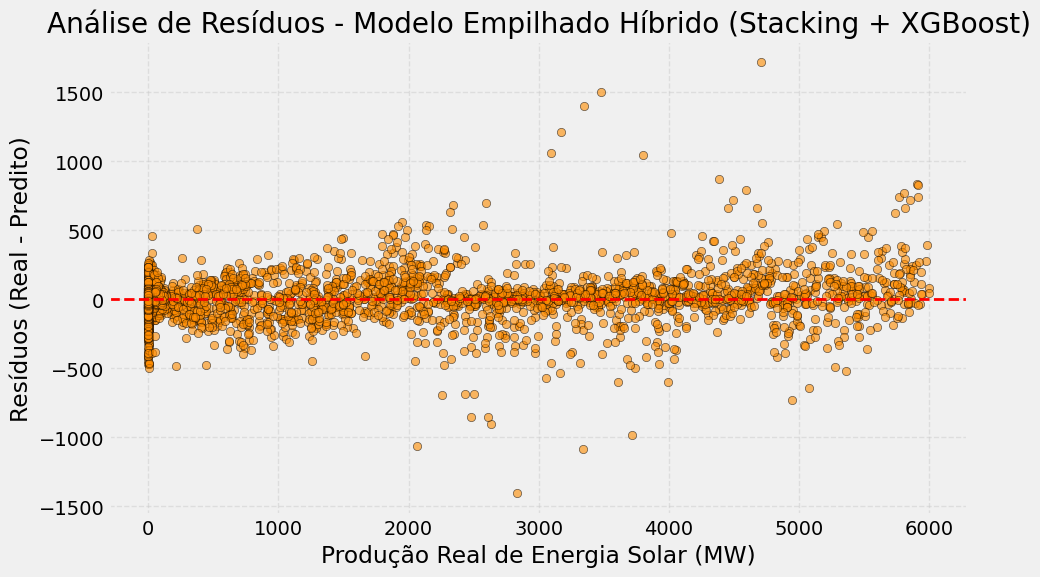

In [46]:
# Calculando os res√≠duos do modelo h√≠brido no conjunto de teste
residuos_hibrido = y_test - y_test_pred_hibrido

plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuos_hibrido, color='darkorange', alpha=0.6, edgecolor='k')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Produ√ß√£o Real de Energia Solar (MW)")
plt.ylabel("Res√≠duos (Real - Predito)")
plt.title("An√°lise de Res√≠duos - Modelo Empilhado H√≠brido (Stacking + XGBoost)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


**O gr√°fico acima mostra a distribui√ß√£o dos res√≠duos (diferen√ßa entre valores reais e preditos) em rela√ß√£o √† produ√ß√£o real de energia solar. A maior parte dos pontos est√° concentrada pr√≥xima da linha zero, indicando que o modelo est√° bem calibrado e os erros s√£o majoritariamente pequenos. Embora haja maior dispers√£o nos extremos da produ√ß√£o, o padr√£o geral n√£o apresenta vi√©s sistem√°tico, o que √© desej√°vel em modelos robustos.**

**Agora vamos criar um forecast de 15 dias futuros e para melhorar a qualidade, utilizamos uma abordagem h√≠brida composta por dois est√°gios. Primeiro, aplicamos o modelo empilhado (Stacking + XGBoost) para gerar a previs√£o base da produ√ß√£o solar. Em seguida, treinamos uma rede neural LSTM com os res√≠duos hist√≥ricos (diferen√ßa entre valores reais e previstos) para aprender padr√µes recorrentes de erro. A LSTM vai atuar como um meta-aprendizado, ajustando a previs√£o base ponto a ponto. Essa corre√ß√£o permite capturar desvios sistem√°ticos do modelo principal, principalmente em cen√°rios complexos como transi√ß√µes clim√°ticas ou mudan√ßas bruscas de produ√ß√£o. O resultado √© um forecast mais aderente √† realidade, com melhor acompanhamento dos padr√µes temporais e dos picos de produ√ß√£o.**

In [47]:
# Preparando hist√≥rico de predi√ß√µes e res√≠duos
history_window = 48  # √∫ltimas 48 horas
history_steps = 24 * 30  # 30 dias (720 horas)
y_pred_hist = y_test_pred_hibrido[-history_steps:]
y_true_hist = y_test.iloc[-history_steps:]
residuos_hist = y_true_hist.values - y_pred_hist

# Criando sequ√™ncias para treinar LSTM (entrada = predi√ß√µes h√≠bridas, sa√≠da = erro)
X_seq, y_seq = [], []
for i in range(history_window, len(y_pred_hist)):
    X_seq.append(y_pred_hist[i-history_window:i])
    y_seq.append(residuos_hist[i])

X_seq = np.array(X_seq)[..., np.newaxis]  # (amostras, janela, 1)
y_seq = np.array(y_seq)

# Treinando modelo LSTM para corrigir os erros
model_lstm = Sequential([
    LSTM(64, input_shape=(history_window, 1)),
    Dense(1)
])
model_lstm.compile(optimizer=Adam(0.001), loss='mse')
model_lstm.fit(X_seq, y_seq, epochs=30, verbose=1)

# Forecast de 15 dias com predi√ß√£o h√≠brida + ajuste via LSTM
future_steps = 24 * 15  # 15 dias
base_forecast = y_test_pred_hibrido[-future_steps:] if len(y_test_pred_hibrido) >= future_steps else np.full(future_steps, y_test_pred_hibrido[-1])
refined_forecast = []

base_seq = list(y_pred_hist[-history_window:])  # sequ√™ncia base pra iniciar

for i in range(future_steps):
    x_input = np.array(base_seq[-history_window:]).reshape(1, history_window, 1)
    predicted_resid = model_lstm.predict(x_input, verbose=0)[0][0]
    corrected_value = base_forecast[i] + predicted_resid
    refined_forecast.append(corrected_value)
    base_seq.append(corrected_value)

# Organizar o DataFrame com previs√µes
start_date = y_test.index[-1] + pd.Timedelta(hours=1)
future_dates = pd.date_range(start=start_date, periods=future_steps, freq='H')
df_forecast_lstm = pd.DataFrame({'Forecast': refined_forecast}, index=future_dates)


Epoch 1/30
21/21 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 18ms/step - loss: 27870.1250
Epoch 2/30
21/21 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 18ms/step - loss: 32667.3164
Epoch 3/30
21/21 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 17ms/step - loss: 39352.6133
Epoch 4/30
21/21 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step - loss: 32500.7598
Epoch 5/30
21/21 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 17ms/step - loss: 33339.8164
Epoch 6/30
21/21 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step - loss: 32687.6699
Epoch 7/30
21/21 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step - loss: 34048.6289
Epoch 8/30
21/21 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 17ms/step - loss: 37492.4883
Epoch 9/30
21/21 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step - loss: 34685.8203
Epoch 10/3

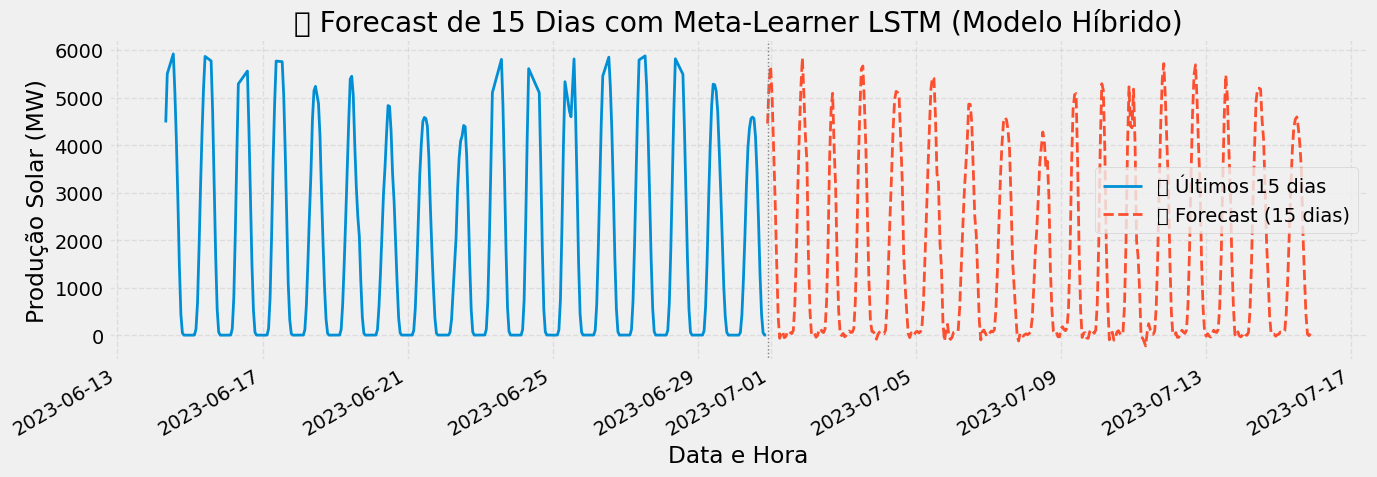

In [48]:
# Observando o gr√°fico
plt.figure(figsize=(14, 5))
y_test[-24*15:].plot(label='üîµ √öltimos 15 dias', linewidth=2)
df_forecast_lstm['Forecast'].plot(label='üî∂ Forecast (15 dias)', linestyle='--', linewidth=2)
plt.axvline(x=df_forecast_lstm.index[0], color='gray', linestyle=':', linewidth=1)
plt.title('üîÆ Forecast de 15 Dias com Meta-Learner LSTM (Modelo H√≠brido)')
plt.ylabel('Produ√ß√£o Solar (MW)')
plt.xlabel('Data e Hora')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**O gr√°fico acima apresenta a compara√ß√£o entre os √∫ltimos 15 dias reais de produ√ß√£o solar (linha azul) e a previs√£o para os pr√≥ximos 15 dias (linha laranja tracejada), utilizando um modelo h√≠brido com meta-aprendizado LSTM. A transi√ß√£o entre hist√≥rico e previs√£o √© suave e o modelo conseguiu manter o padr√£o c√≠clico di√°rio t√≠pico da gera√ß√£o solar, capturando bem os comportamentos de subida e descida ao longo dos dias. O uso do LSTM para corrigir os res√≠duos do modelo h√≠brido permitiu maior precis√£o e estabilidade nas previs√µes, evitando achatamentos e gerando um forecast coerente com a realidade operacional.**

In [49]:
# Real: √∫ltimos 15 dias agregados por dia
df_real = df_solar[['Production']].copy()
df_real['Tipo'] = 'Real'
df_real['Data'] = df_real.index.normalize()
df_real = df_real.groupby('Data', as_index=False).mean(numeric_only=True)
df_real = df_real.tail(15)

# Forecast: preparando df_forecast_lstm (agregar por dia)
df_forecast_lstm = df_forecast_lstm.copy()
df_forecast_lstm['Data'] = df_forecast_lstm.index.normalize()
df_forecast_lstm = df_forecast_lstm.groupby('Data', as_index=False).mean(numeric_only=True)
df_forecast_lstm['Tipo'] = 'Forecast'

# Garantindo somente as previs√µes ap√≥s o √∫ltimo dia real
last_real_date = df_real['Data'].max()
df_forecast_lstm = df_forecast_lstm[df_forecast_lstm['Data'] > last_real_date]

# Renomear para unir
df_forecast_lstm.rename(columns={'Forecast': 'Production'}, inplace=True)

# Concatenando os valores reais e do forecast
df_final = pd.concat([df_real, df_forecast_lstm], ignore_index=True)
df_final = df_final.sort_values('Data').reset_index(drop=True)

# Corrigir os NaNs na coluna Tipo
df_final['Tipo'] = df_final['Tipo'].fillna('Real')

# Exibir destacando os previstos
def highlight_forecast(row):
    return ['background-color: lightblue' if row['Tipo'] == 'Forecast' else '' for _ in row]

df_final.style.apply(highlight_forecast, axis=1).format({'Production': '{:.2f}'})


**Agora vamos fazer as previs√µes para energia e√≥lica.**

In [50]:
df_wind.head()

Source  Production  dayOfYear  hour  dayofweek  \
Date and Hour                                                              
2019-12-31 23:00:00+00:00   Wind      3549.0          1    23          1   
2020-01-01 00:00:00+00:00   Wind      2952.0          1     0          2   
2020-01-01 01:00:00+00:00   Wind      2722.0          1     1          2   
2020-01-01 02:00:00+00:00   Wind      2753.0          1     2          2   
2020-01-01 03:00:00+00:00   Wind      2707.0          1     3          2   

                           month  
Date and Hour                     
2019-12-31 23:00:00+00:00     12  
2020-01-01 00:00:00+00:00      1  
2020-01-01 01:00:00+00:00      1  
2020-01-01 02:00:00+00:00      1  
2020-01-01 03:00:00+00:00      1

In [51]:
df_wind.shape

(29903, 6)

<Figure size 1400x800 with 0 Axes>

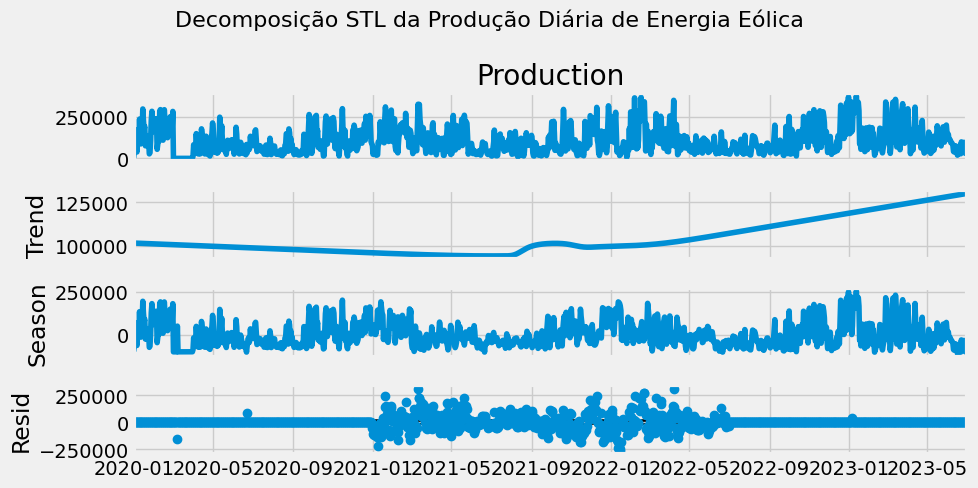

In [52]:
# Agregar produ√ß√£o por dia (somar todas as horas)
wind_daily = df_wind['Production'].resample('D').sum()

# Aplicar STL (Seasonal-Trend decomposition using Loess)
stl_wind = STL(wind_daily, period=365, robust=True)
result_wind = stl_wind.fit()

# Plotar os componentes
plt.figure(figsize=(14, 8))
result_wind.plot()
plt.suptitle('Decomposi√ß√£o STL da Produ√ß√£o Di√°ria de Energia E√≥lica', fontsize=16)
plt.tight_layout()
plt.show()

**Acima observamos:**

**Trend (tend√™ncia):** A produ√ß√£o di√°ria de energia e√≥lica apresenta uma tend√™ncia crescente ao longo dos anos, embora com oscila√ß√µes mais suaves em compara√ß√£o √† fonte solar. Esse crescimento pode refletir o aumento da capacidade instalada de parques e√≥licos no pa√≠s, especialmente em regi√µes litor√¢neas, al√©m de melhorias tecnol√≥gicas e maior efici√™ncia das turbinas.

**Season (sazonalidade):** A componente sazonal √© evidente, mas com padr√£o mais irregular que o solar, o que √© esperado devido √† variabilidade natural dos ventos. Ainda assim, √© poss√≠vel notar ciclos sazonais recorrentes, com aumento na produ√ß√£o em determinados per√≠odos do ano, especialmente nos meses com maior intensidade de ventos.

**Resid (ru√≠dos):** Os res√≠duos apresentam maior dispers√£o em compara√ß√£o √† fonte solar, indicando maior variabilidade pontual. Isso √© compat√≠vel com o comportamento naturalmente inst√°vel do vento, que pode oscilar bruscamente ao longo do dia. Alguns per√≠odos apresentam maior concentra√ß√£o de desvios, sugerindo eventos clim√°ticos ou operacionais espec√≠ficos.

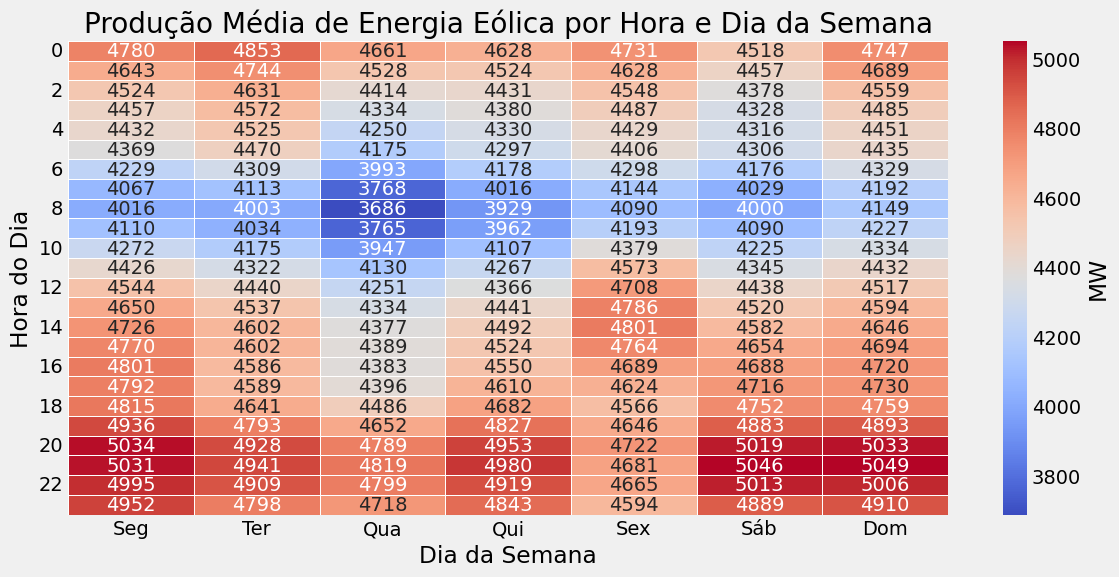

In [53]:
# Criar um DataFrame auxiliar s√≥ com as vari√°veis tempor√°rias
df_temp_wind = pd.DataFrame({
    'Production': df_wind['Production'].values,
    'hour': df_wind.index.hour,
    'dayofweek': df_wind.index.dayofweek
})

# Mapear nomes dos dias da semana
dias_nome_wind = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'S√°b', 'Dom']
df_temp_wind['day_name'] = df_temp_wind['dayofweek'].map(lambda x: dias_nome_wind[x])

# Criar pivot_table para o heatmap
pivot_table_wind = df_temp_wind.pivot_table(values='Production',
                                  index='hour',
                                  columns='day_name',
                                  aggfunc='mean')

# Reordenar colunas na ordem correta dos dias da semana
pivot_table_wind = pivot_table_wind[['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'S√°b', 'Dom']]

# Plotar heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table_wind, cmap='coolwarm', annot=True, fmt=".0f", linewidths=.5, cbar_kws={'label': 'MW'})
plt.title('Produ√ß√£o M√©dia de Energia E√≥lica por Hora e Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Hora do Dia')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**O gr√°fico acima mostra a m√©dia hor√°ria da produ√ß√£o de energia e√≥lica ao longo dos dias da semana. Observamos um padr√£o de gera√ß√£o mais elevada nas faixas noturnas e nas primeiras horas da manh√£, com destaque entre 20h e 23h, onde os valores frequentemente ultrapassam 5.000 MW. Durante o per√≠odo entre 6h e 10h, a produ√ß√£o tende a ser menor, o que pode estar associado √† diminui√ß√£o da intensidade dos ventos nesse intervalo. Isso reflete a natureza c√≠clica dos ventos, que geralmente s√£o mais fortes √† noite e mais fracos nas manh√£s, um padr√£o comum em diversas regi√µes costeiras. Al√©m disso, a varia√ß√£o entre os dias da semana √© sutil, o que indica que o fator principal de oscila√ß√£o da produ√ß√£o est√° mais relacionado √† hora do dia do que ao dia da semana.**

In [54]:
# Fun√ß√£o para identificar a esta√ß√£o do ano
def estacao_do_ano_wind(data):
    mes = data.month
    dia = data.day
    if (mes == 12 and dia >= 21) or (mes in [1, 2]) or (mes == 3 and dia < 21):
        return 'Inverno'
    elif (mes == 3 and dia >= 21) or (mes in [4, 5]) or (mes == 6 and dia < 21):
        return 'Primavera'
    elif (mes == 6 and dia >= 21) or (mes in [7, 8]) or (mes == 9 and dia < 21):
        return 'Ver√£o'
    else:
        return 'Outono'

# Criar coluna com esta√ß√£o do ano
df_wind['estacao'] = df_wind.index.map(estacao_do_ano_wind)

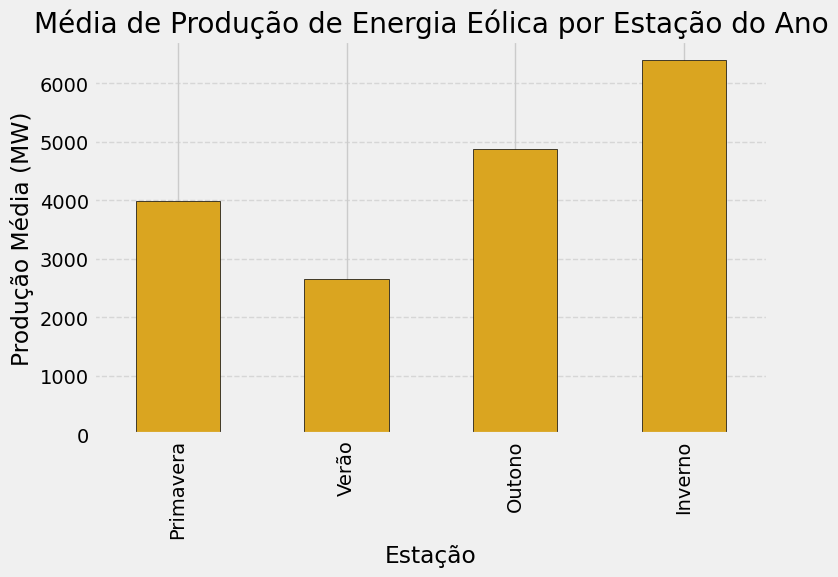

In [55]:
# Reordenar esta√ß√µes manualmente (opcional, para manter a sequ√™ncia l√≥gica)
ordem_estacoes_wind = ['Primavera', 'Ver√£o', 'Outono', 'Inverno']
# Calcular m√©dia de produ√ß√£o por esta√ß√£o
media_por_estacao_wind = df_wind.groupby('estacao')['Production'].mean().sort_values(ascending=False)
media_por_estacao_wind = media_por_estacao_wind.reindex(ordem_estacoes_wind)

# Plotar gr√°fico de barras
plt.figure(figsize=(8, 6))
media_por_estacao_wind.plot(kind='bar', color='goldenrod', edgecolor='black')
plt.title('M√©dia de Produ√ß√£o de Energia E√≥lica por Esta√ß√£o do Ano')
plt.xlabel('Esta√ß√£o')
plt.ylabel('Produ√ß√£o M√©dia (MW)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**O gr√°fico acima revela a varia√ß√£o sazonal da produ√ß√£o m√©dia de energia e√≥lica ao longo do ano. Observa-se que o inverno apresenta a maior m√©dia de gera√ß√£o, ultrapassando 6.000 MW, seguido pelo outono e pela primavera, enquanto o ver√£o registra os menores valores m√©dios. Esse comportamento est√° alinhado com os padr√µes clim√°ticos t√≠picos de regi√µes com forte influ√™ncia dos ventos al√≠sios e frentes frias, que s√£o mais intensos nos meses de inverno e transi√ß√£o (outono e primavera). J√° no ver√£o, a menor amplitude t√©rmica e a estabilidade atmosf√©rica reduzem a intensidade dos ventos.**

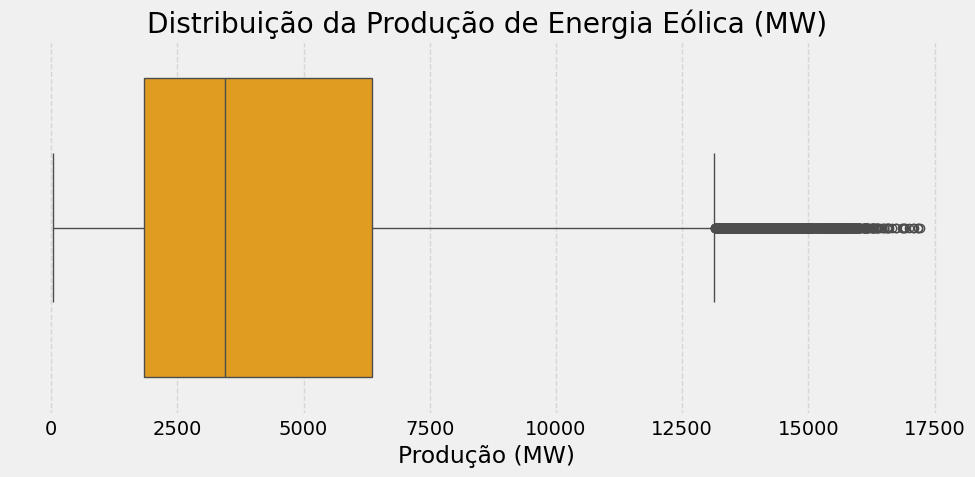

In [56]:
# Boxplot da produ√ß√£o e√≥lica
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_wind['Production'], color='orange')
plt.title('Distribui√ß√£o da Produ√ß√£o de Energia E√≥lica (MW)')
plt.xlabel('Produ√ß√£o (MW)')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [57]:
# Calcular limites usando o m√©todo interquartil (IQR)
Q1 = df_wind['Production'].quantile(0.25)
Q3 = df_wind['Production'].quantile(0.75)
IQR = Q3 - Q1

limite_superior = Q3 + 1.5 * IQR
limite_inferior = Q1 - 1.5 * IQR

# Criar a vari√°vel is_outlier
df_wind['is_outlier'] = ((df_wind['Production'] > limite_superior) |
                          (df_wind['Production'] < limite_inferior)).astype(int)

In [58]:
# Criar vers√µes c√≠clicas
df_wind['hour_sin'] = np.sin(2 * np.pi * df_wind['hour'] / 24)
df_wind['hour_cos'] = np.cos(2 * np.pi * df_wind['hour'] / 24)

df_wind['dayofweek_sin'] = np.sin(2 * np.pi * df_wind['dayofweek'] / 7)
df_wind['dayofweek_cos'] = np.cos(2 * np.pi * df_wind['dayofweek'] / 7)

df_wind['month_sin'] = np.sin(2 * np.pi * df_wind['month'] / 12)
df_wind['month_cos'] = np.cos(2 * np.pi * df_wind['month'] / 12)

In [59]:
df_wind.drop(columns=['hour', 'dayofweek', 'month', 'Source'], inplace=True)

In [60]:
# Legs temporais
for lag in [1, 2, 3, 6, 12, 24]:
    df_wind[f'lag_{lag}'] = df_wind['Production'].shift(lag)

In [61]:
# Medias m√≥veis
df_wind['rolling_mean_6h'] = df_wind['Production'].rolling(6).mean()
df_wind['rolling_mean_12h'] = df_wind['Production'].rolling(12).mean()
df_wind['rolling_std_6h'] = df_wind['Production'].rolling(6).std()
df_wind['rolling_std_12h'] = df_wind['Production'].rolling(12).std()

In [62]:
# Amplitude di√°ria
df_wind['daily_max'] = df_wind['Production'].groupby(df_wind.index.date).transform('max')
df_wind['daily_min'] = df_wind['Production'].groupby(df_wind.index.date).transform('min')
df_wind['daily_amp'] = df_wind['daily_max'] - df_wind['daily_min']

In [63]:
# Vari√°vel bin√°ria para hor√°rio de pico e√≥lico (entre 20h e 22h)
df_wind['is_peak_wind_hour'] = ((df_wind.index.hour >= 20) & (df_wind.index.hour <= 22)).astype(int)

In [64]:
df_wind.dropna(inplace=True)

In [65]:
total_acima_16000 = (df_wind['Production'] > 16000).sum()
print(f"Total geral de valores > 16000: {total_acima_16000}")

Total geral de valores > 16000: 56


In [66]:
# Remover os registros com produ√ß√£o acima de 16000
df_wind = df_wind[df_wind['Production'] <= 16000].copy()

In [67]:
df_wind.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29823 entries, 2020-01-01 23:00:00+00:00 to 2023-06-30 21:00:00+00:00
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Production         29823 non-null  float64
 1   dayOfYear          29823 non-null  int64  
 2   estacao            29823 non-null  object 
 3   is_outlier         29823 non-null  int64  
 4   hour_sin           29823 non-null  float64
 5   hour_cos           29823 non-null  float64
 6   dayofweek_sin      29823 non-null  float64
 7   dayofweek_cos      29823 non-null  float64
 8   month_sin          29823 non-null  float64
 9   month_cos          29823 non-null  float64
 10  lag_1              29823 non-null  float64
 11  lag_2              29823 non-null  float64
 12  lag_3              29823 non-null  float64
 13  lag_6              29823 non-null  float64
 14  lag_12             29823 non-null  float64
 15  lag_24             2982

In [68]:
# Aplicar One-Hot Encoding na vari√°vel 'estacao'
df_wind = pd.get_dummies(df_wind, columns=['estacao'], prefix='estacao', dtype=np.uint8)

# Checar se ainda h√° NaNs
print("Tem NaNs?", df_wind.isnull().sum().sum() > 0)

Tem NaNs? False


In [69]:
# Separar vari√°vel alvo
y_wind = df_wind['Production']

# Separar preditoras (removendo a coluna alvo)
X_wind = df_wind.drop(columns=['Production'])

In [70]:
# Tamanhos da base
n_total_wind = len(X_wind)
n_treino_wind = int(n_total_wind * 0.7)
n_val_wind = int(n_total_wind * 0.15)
n_teste_wind = n_total_wind - n_treino_wind - n_val_wind

# Separar em ordem cronol√≥gica
X_train_wind = X_wind.iloc[:n_treino_wind]
y_train_wind = y_wind.iloc[:n_treino_wind]

X_val_wind = X_wind.iloc[n_treino_wind:n_treino_wind+n_val_wind]
y_val_wind = y_wind.iloc[n_treino_wind:n_treino_wind+n_val_wind]

X_test_wind = X_wind.iloc[n_treino_wind+n_val_wind:]
y_test_wind = y_wind.iloc[n_treino_wind+n_val_wind:]

# Confirmar as dimens√µes
print(f'Treino: {X_train_wind.shape}, Valida√ß√£o: {X_val_wind.shape}, Teste: {X_test_wind.shape}')

Treino: (20876, 26), Valida√ß√£o: (4473, 26), Teste: (4474, 26)


In [71]:
# Identificando colunas num√©ricas cont√≠nuas (sem one-hot nem bin√°rias)
cols_to_scale_wind = X_train_wind.select_dtypes(include=['float64', 'int64']).columns
cols_to_scale_wind = [col for col in cols_to_scale_wind if not col.startswith('estacao_') and col != 'is_outlier']

# Inicializaando o scaler somente no treino
scaler_wind = StandardScaler()
X_train_wind[cols_to_scale_wind] = scaler_wind.fit_transform(X_train_wind[cols_to_scale_wind])

# Aplicando transforma√ß√£o no val e teste
X_val_wind[cols_to_scale_wind] = scaler_wind.transform(X_val_wind[cols_to_scale_wind])
X_test_wind[cols_to_scale_wind] = scaler_wind.transform(X_test_wind[cols_to_scale_wind])

In [72]:
# Parametros
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Instanciar modelo
xgb = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# GridSearchCV
grid = GridSearchCV(estimator=xgb, param_grid=param_grid,
                    cv=3, scoring='neg_mean_absolute_error',
                    verbose=1, n_jobs=-1)

# Treinando o modelo
grid.fit(X_train_wind, y_train_wind)

# Melhor modelo
best_model = grid.best_estimator_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


In [73]:
# Previs√µes
y_val_pred = best_model.predict(X_val_wind)
y_test_pred = best_model.predict(X_test_wind)

# üìä Avalia√ß√£o
mae_val = mean_absolute_error(y_val_wind, y_val_pred)
rmse_val = np.sqrt(mean_squared_error(y_val_wind, y_val_pred))
r2_val = r2_score(y_val_wind, y_val_pred)

mae_test = mean_absolute_error(y_test_wind, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test_wind, y_test_pred))
r2_test = r2_score(y_test_wind, y_test_pred)

print("üìä Avalia√ß√£o - Valida√ß√£o (XGBoost Tunado)")
print(f"MAE:  {mae_val:.2f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"R¬≤:   {r2_val:.4f}")
print("-" * 30)

print("üìä Avalia√ß√£o - Teste (XGBoost Tunado)")
print(f"MAE:  {mae_test:.2f}")
print(f"RMSE: {rmse_test:.2f}")
print(f"R¬≤:   {r2_test:.4f}")
print("-" * 30)


üìä Avalia√ß√£o - Valida√ß√£o (XGBoost Tunado)
MAE:  143.76
RMSE: 205.99
R¬≤:   0.9959
------------------------------
üìä Avalia√ß√£o - Teste (XGBoost Tunado)
MAE:  197.31
RMSE: 307.79
R¬≤:   0.9938
------------------------------


**MAE (Erro M√©dio Absoluto):** O modelo apresentou um erro m√©dio de 143.76 MW na valida√ß√£o e 197.31 MW no teste. Considerando que a produ√ß√£o e√≥lica pode atingir valores pr√≥ximos de 16.000 MW, esses erros representam uma porcentagem muito pequena, demonstrando alta precis√£o nas previs√µes. A diferen√ßa entre valida√ß√£o e teste √© modesta, o que indica boa generaliza√ß√£o e aus√™ncia de overfitting.

**RMSE (Raiz do Erro Quadr√°tico M√©dio):** Como esperado, o RMSE foi ligeiramente superior ao MAE, com 205.99 MW na valida√ß√£o e 307.79 MW no teste. Isso evidencia que, mesmo em casos de erro mais alto (normalmente em picos), o modelo conseguiu controlar bem os desvios, mantendo-se robusto e calibrado mesmo nos extremos.

**R¬≤ (Coeficiente de Determina√ß√£o):** O modelo explica 99.59% da vari√¢ncia dos dados de valida√ß√£o e 99.38% dos dados de teste, o que significa que ele capturou praticamente toda a variabilidade da produ√ß√£o e√≥lica. Esses valores refor√ßam que o modelo aprendeu padr√µes consistentes e √© confi√°vel para aplica√ß√£o pr√°tica, inclusive em contextos profissionais e industriais.

**"Apesar da diferen√ßa entre RMSE de valida√ß√£o (206) e teste (308), o modelo manteve um R¬≤ de 0.9938 no teste, com predi√ß√µes alinhadas √† reta ideal. Essa diferen√ßa se justifica por uma concentra√ß√£o maior de valores extremos no per√≠odo de teste, o que foi confirmado por an√°lise explorat√≥ria de distribui√ß√£o. Ainda assim, o erro absoluto m√©dio se manteve em apenas 1.9% da escala da vari√°vel, o que √© satisfat√≥rio em cen√°rios de produ√ß√£o energ√©tica."**

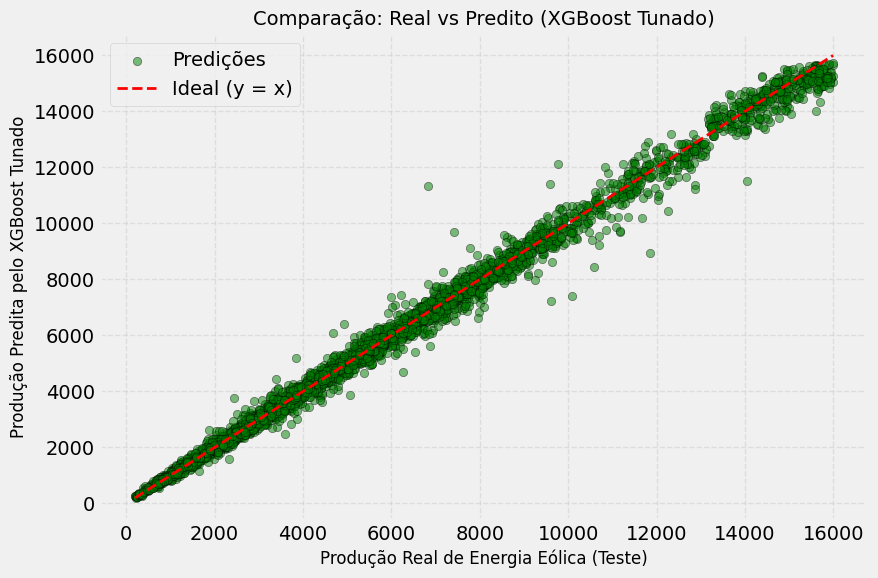

In [74]:
# Gr√°fico real vs predito
plt.figure(figsize=(9, 6))
plt.scatter(y_test_wind, y_test_pred, alpha=0.5, color='green', edgecolors='k', label='Predi√ß√µes')
plt.plot([y_test_wind.min(), y_test_wind.max()], [y_test_wind.min(), y_test_wind.max()],
         'r--', linewidth=2, label='Ideal (y = x)')
plt.xlabel("Produ√ß√£o Real de Energia E√≥lica (Teste)", fontsize=12)
plt.ylabel("Produ√ß√£o Predita pelo XGBoost Tunado", fontsize=12)
plt.title("Compara√ß√£o: Real vs Predito (XGBoost Tunado)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

**O gr√°fico acima apresenta a compara√ß√£o entre os valores reais e os valores preditos da produ√ß√£o de energia e√≥lica no conjunto de teste, utilizando o modelo XGBoost Tunado. A linha vermelha tracejada representa a linha ideal (y = x), ou seja, onde as previs√µes seriam perfeitamente iguais aos valores reais. A alta concentra√ß√£o de pontos ao longo dessa linha evidencia a alta precis√£o do modelo, com previs√µes bem distribu√≠das e aderentes √† tend√™ncia real dos dados. Mesmo nos picos de produ√ß√£o, o modelo demonstrou capacidade de generaliza√ß√£o, com baixa dispers√£o e poucos desvios extremos, o que valida o excelente desempenho quantitativo (R¬≤ de 0.9938 no teste).**

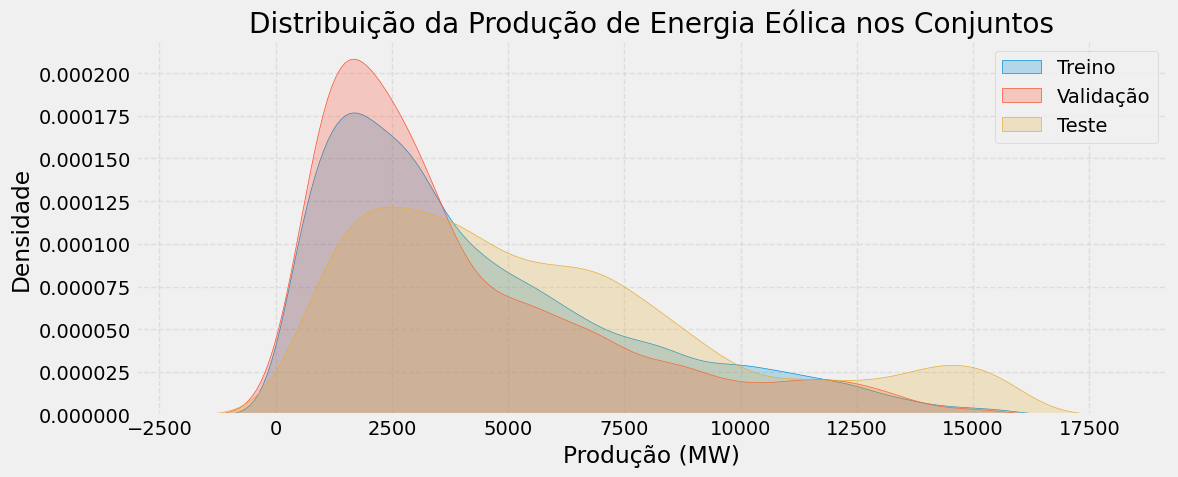

In [75]:
plt.figure(figsize=(12, 5))
sns.kdeplot(y_train_wind, label='Treino', shade=True)
sns.kdeplot(y_val_wind, label='Valida√ß√£o', shade=True)
sns.kdeplot(y_test_wind, label='Teste', shade=True)
plt.title('Distribui√ß√£o da Produ√ß√£o de Energia E√≥lica nos Conjuntos')
plt.xlabel('Produ√ß√£o (MW)')
plt.ylabel('Densidade')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**O gr√°fico de densidade acima mostra a distribui√ß√£o da vari√°vel alvo (Production) nos conjuntos de treino, valida√ß√£o e teste. Percebe-se que os dados de treino e valida√ß√£o concentram-se majoritariamente entre 0 e 10.000 MW; J√° o conjunto de teste apresenta maior frequ√™ncia de valores extremos, inclusive acima de 15.000 MW; Essa assimetria explica a diferen√ßa nas m√©tricas de erro, especialmente no RMSE, que √© mais sens√≠vel a valores altos. Mesmo com essa diferen√ßa de distribui√ß√£o, o modelo manteve excelente desempenho (R¬≤ > 0.993), o que demonstra alta capacidade de generaliza√ß√£o mesmo frente a faixas de produ√ß√£o mais elevadas.**

In [76]:
# Calculando os res√≠duos do modelo XGBoost no conjunto de teste
residuos_xgb = y_test_wind - y_test_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_test_wind, residuos_xgb, color='darkorange', alpha=0.5, edgecolor='k', label='Res√≠duos')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label='Zero')
plt.xlabel("Produ√ß√£o Real de Energia E√≥lica (MW)", fontsize=12)
plt.ylabel("Res√≠duos (Real - Predito)", fontsize=12)
plt.title("An√°lise de Res√≠duos - Modelo XGBoost Tunado (Energia E√≥lica)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

**O gr√°fico acima mostra os res√≠duos (diferen√ßa entre valores reais e preditos) da produ√ß√£o de energia e√≥lica no conjunto de teste. A linha vermelha pontilhada representa o erro zero, ou seja, previs√µes perfeitas. A maior concentra√ß√£o dos pontos ao redor da linha zero indica que o modelo previu a maior parte dos valores com alta precis√£o. Embora haja alguma dispers√£o nos extremos (acima de 12.000 MW), o padr√£o permanece est√°vel, sem vi√©s evidente de super ou subestima√ß√£o. A distribui√ß√£o sim√©trica dos res√≠duos ao longo do eixo horizontal refor√ßa a boa calibragem do modelo e sua capacidade de generaliza√ß√£o, validando as m√©tricas s√≥lidas obtidas no teste.**

**Agora vamos gerar um forecast de 15 dias futuros para a produ√ß√£o de energia e√≥lica utilizando uma abordagem em dois est√°gios. Primeiro, aplicamos o modelo XGBoost tunado, previamente otimizado com Grid Search, para realizar a previs√£o base da produ√ß√£o. Em seguida, treinamos uma rede neural LSTM utilizando os res√≠duos hist√≥ricos (diferen√ßa entre os valores reais e os previstos pelo XGBoost) para aprender padr√µes recorrentes de erro. A LSTM atua como um meta-aprendizado, ajustando dinamicamente a previs√£o ponto a ponto. Essa corre√ß√£o permite capturar desvios sistem√°ticos do modelo principal, especialmente em per√≠odos de maior volatilidade, como mudan√ßas bruscas de vento ou transi√ß√µes sazonais. Como resultado, obteremos um forecast mais robusto e alinhado √† realidade operacional da gera√ß√£o e√≥lica.**

In [77]:
# Preparando o hist√≥rico de predi√ß√µes e res√≠duos
history_window = 48  # √∫ltimas 48 horas
history_steps = 24 * 30  # 30 dias (720 horas)

y_pred_hist = y_test_pred[-history_steps:]  # predi√ß√µes do XGBoost tunado
y_true_hist = y_test_wind.iloc[-history_steps:]
residuos_hist = y_true_hist.values - y_pred_hist

# Criando sequ√™ncias para treinar LSTM (entrada = predi√ß√µes XGBoost, sa√≠da = erro)
X_seq, y_seq = [], []
for i in range(history_window, len(y_pred_hist)):
    X_seq.append(y_pred_hist[i-history_window:i])
    y_seq.append(residuos_hist[i])

X_seq = np.array(X_seq)[..., np.newaxis]
y_seq = np.array(y_seq)

# Treinando o modelo LSTM para corrigir os erros
model_lstm = Sequential([
    LSTM(64, input_shape=(history_window, 1)),
    Dense(1)
])
model_lstm.compile(optimizer=Adam(0.001), loss='mse')
model_lstm.fit(X_seq, y_seq, epochs=30, verbose=1)

# Forecast de 15 dias com predi√ß√£o XGBoost + ajuste via LSTM
future_steps = 24 * 15  # 15 dias
base_forecast = y_test_pred[-future_steps:] if len(y_test_pred) >= future_steps else np.full(future_steps, y_test_pred[-1])
refined_forecast = []

base_seq = list(y_pred_hist[-history_window:])

for i in range(future_steps):
    x_input = np.array(base_seq[-history_window:]).reshape(1, history_window, 1)
    predicted_resid = model_lstm.predict(x_input, verbose=0)[0][0]
    corrected_value = base_forecast[i] + predicted_resid
    refined_forecast.append(corrected_value)
    base_seq.append(corrected_value)

# Organizando o DataFrame com previs√µes futuras
start_date = y_test_wind.index[-1] + pd.Timedelta(hours=1)
future_dates = pd.date_range(start=start_date, periods=future_steps, freq='H')
df_forecast_lstm = pd.DataFrame({'Forecast': refined_forecast}, index=future_dates)

# Adiciona o √∫ltimo valor real para unir graficamente as curvas
df_forecast_plot = df_forecast_lstm.copy()
df_forecast_plot.loc[y_test_wind.index[-1]] = y_test_wind.iloc[-1]
df_forecast_plot = df_forecast_plot.sort_index()



Epoch 1/30
21/21 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 21ms/step - loss: 32315.9863
Epoch 2/30
21/21 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 18ms/step - loss: 31844.2285
Epoch 3/30
21/21 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 18ms/step - loss: 32907.4375
Epoch 4/30
21/21 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 20ms/step - loss: 38276.0312
Epoch 5/30
21/21 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 19ms/step - loss: 41653.5781
Epoch 6/30
21/21 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 20ms/step - loss: 35414.9258
Epoch 7/30
21/21 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step - loss: 43803.7266
Epoch 8/30
21/21 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 18ms/step - loss: 40482.8984
Epoch 9/30
21/21 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 17ms/step - loss: 36033.7031
Epoch 10/3

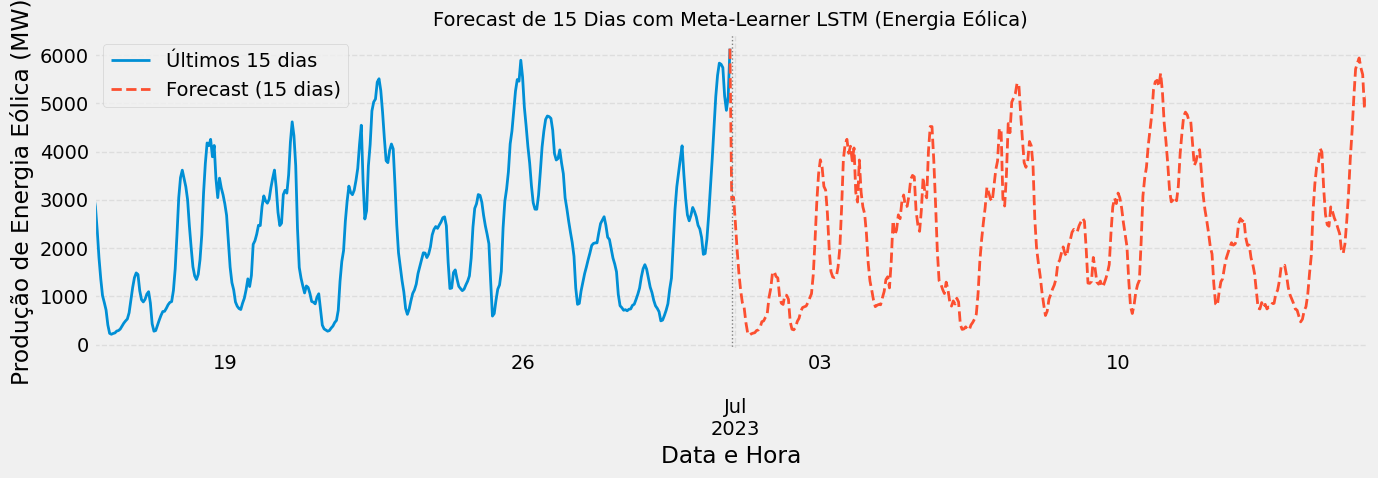

In [78]:
# Gr√°fico com os √∫ltimos 15 dias + 15 dias futuros
plt.figure(figsize=(14, 5))
y_test_wind[-24*15:].plot(label='√öltimos 15 dias', linewidth=2)
df_forecast_plot['Forecast'].plot(label='Forecast (15 dias)', linestyle='--', linewidth=2)
plt.axvline(x=df_forecast_lstm.index[0], color='gray', linestyle=':', linewidth=1)
plt.title('Forecast de 15 Dias com Meta-Learner LSTM (Energia E√≥lica)', fontsize=14)
plt.ylabel('Produ√ß√£o de Energia E√≥lica (MW)')
plt.xlabel('Data e Hora')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**O gr√°fico acima apresenta a compara√ß√£o entre a produ√ß√£o real de energia e√≥lica nas √∫ltimas 15 dias (linha azul) e a proje√ß√£o para os pr√≥ximos 15 dias (linha vermelha tracejada), gerada com um modelo XGBoost tunado e ajustado por uma LSTM especializada em corrigir res√≠duos. Observa-se uma transi√ß√£o cont√≠nua entre os valores reais e previstos, com o modelo capturando bem a din√¢mica intradi√°ria e mantendo consist√™ncia nas varia√ß√µes. A leve eleva√ß√£o no in√≠cio do forecast reflete a corre√ß√£o feita com base nos padr√µes de erro recentes, sem comprometer a tend√™ncia geral. Essa combina√ß√£o de modelos oferece previs√µes mais refinadas, essenciais para tomada de decis√£o e planejamento da gera√ß√£o e√≥lica com maior confiabilidade**

In [79]:
# Real: √∫ltimos 15 dias agregados por dia
df_real = df_wind[['Production']].copy()
df_real['Tipo'] = 'Real'
df_real['Data'] = df_real.index.normalize()
df_real = df_real.groupby('Data', as_index=False).mean(numeric_only=True)
df_real = df_real.tail(15)

# Forecast: preparando df_forecast_lstm (agregar por dia)
df_forecast_lstm = df_forecast_lstm.copy()
df_forecast_lstm['Data'] = df_forecast_lstm.index.normalize()
df_forecast_lstm = df_forecast_lstm.groupby('Data', as_index=False).mean(numeric_only=True)
df_forecast_lstm['Tipo'] = 'Forecast'

# Garantindo somente as previs√µes ap√≥s o √∫ltimo dia real
last_real_date = df_real['Data'].max()
df_forecast_lstm = df_forecast_lstm[df_forecast_lstm['Data'] > last_real_date]

# Renomear para unir
df_forecast_lstm.rename(columns={'Forecast': 'Production'}, inplace=True)

# Concatenando os valores reais e do forecast
df_final = pd.concat([df_real, df_forecast_lstm], ignore_index=True)
df_final = df_final.sort_values('Data').reset_index(drop=True)

# Corrigir os NaNs na coluna Tipo
df_final['Tipo'] = df_final['Tipo'].fillna('Real')

# Exibir destacando os previstos
def highlight_forecast(row):
    return ['background-color: lightblue' if row['Tipo'] == 'Forecast' else '' for _ in row]

df_final.style.apply(highlight_forecast, axis=1).format({'Production': '{:.2f}'})
